In [1]:
# !git clone https://github.com/donghwijung/GOTLoc.git

In [1]:
from args import get_args
import copy
import os
import pickle

import wandb
import rerun
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random 
import torch.nn.functional as F

import torch

import config
from eval_utils import eval
from models import BigGNN
from scene_graph_candidates_extraction import proceed_candidates_extraction, setup_db
'gpu' if torch.cuda.is_available() else 'cpu'

'gpu'

## Подготовка данных

Сцены с OSM.

In [2]:
with open(
    "/home/bukkacha/Desktop/CCM/GOTLoc/data/scene_graphs/osm_cell_graphs_2052.pkl", 
    "rb") as f:
    cell_scene_graphs = pickle.load(f)
cell_graph_keys = list(cell_scene_graphs.keys())

Сцены полученные из текстового запроса.

In [3]:
with open(os.path.join(f"{config.scene_graphs_path}/{config.train_text_graphs_file_name}"), "rb") as f:
    train_scene_graphs = pickle.load(f)
with open(os.path.join(f"{config.scene_graphs_path}/{config.test_text_graphs_file_name}"), "rb") as f:
    test_scene_graphs = pickle.load(f)
with open(os.path.join(f"{config.scene_graphs_path}/{config.val_text_graphs_file_name}"), "rb") as f:
    val_scene_graphs = pickle.load(f)
text_scene_graphs = train_scene_graphs | test_scene_graphs | val_scene_graphs

text_scene_graphs_copy = copy.deepcopy(text_scene_graphs)
for k,v in text_scene_graphs_copy.items():
    cell_id = "_".join(k.split("_")[:2])
    if cell_id not in cell_graph_keys:
        del text_scene_graphs[k]
text_scene_graph_keys = list(text_scene_graphs.keys())

Загружаем модель

In [6]:
model_state_dict = torch.load(
    './data/model_checkpoints/model_osm.pt', 
    weights_only=False)
model = BigGNN(1, 2).to('cuda')
model.load_state_dict(model_state_dict)
model.eval()

BigGNN(
  (TSALayers): ModuleList(
    (0): SimpleTConv()
  )
  (GSALayers): ModuleList(
    (0): SimpleTConv()
  )
  (TCALayers): ModuleList(
    (0): SimpleTConv()
  )
  (GCALayers): ModuleList(
    (0): SimpleTConv()
  )
  (SceneText_MLP): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=600, out_features=300, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=300, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Визуализация работы модели на нескольких последовательностях данных

In [7]:
# Фнкнция для визуализации
def visualize_osmnx_graphs_side_by_side(
        graph1, 
        graph2, 
        pos1=None, 
        pos2=None, 
        figsize=(10, 10), 
        node_size=1000, 
        font_size=12, 
        edge_font_size=12, 
        node_color="#FFE3E3", 
        title1="Graph 1", 
        title2="Graph 2"
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    mapped_labels1 = {n: graph1.nodes[n]["label"] for n in graph1.nodes}
    nx.draw(graph1, pos1, ax=axes[0], with_labels=True, node_color=node_color, 
            node_size=node_size, font_size=font_size, font_weight='bold', 
            edge_color='black', labels=mapped_labels1)
    edge_labels1 = {(u, v): d['edge_relations'] for u, v, d in graph1.edges(data=True)}
    nx.draw_networkx_edge_labels(graph1, pos1, edge_labels=edge_labels1, 
                                 ax=axes[0], font_color='black', font_size=edge_font_size)
    axes[0].set_title(title1)

    mapped_labels2 = {n: graph2.nodes[n]["label"] for n in graph2.nodes}
    nx.draw(graph2, pos2, ax=axes[1], with_labels=True, node_color=node_color, 
            node_size=node_size, font_size=font_size, font_weight='bold', 
            edge_color='black', labels=mapped_labels2)
    edge_labels2 = {(u, v): d['edge_relations'] for u, v, d in graph2.edges(data=True)}
    nx.draw_networkx_edge_labels(graph2, pos2, edge_labels=edge_labels2, 
                                 ax=axes[1], font_color='black', font_size=edge_font_size)
    axes[1].set_title(title2)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{title1}_vs_{title2}.png", dpi=300, bbox_inches='tight')

In [8]:
# Переводит граф сцены в формат osmnx для визуализации
def scene_graph_to_osmnx_graph(scene_graph):
    graph = nx.DiGraph()
    nodes = scene_graph.nodes

    node_ids = []
    pos = {}

    for k,v in nodes.items():
        node_id = k
        node_ids.append(node_id)
        node = v
        graph.add_node(node_id, label=node.label, attribute=node.attributes, features=node.features)
        node_centroid = node.centroid
        pos[node_id] = node_centroid

    edge_relations = scene_graph.edge_relations
    edge_idx = scene_graph.edge_idx

    edge_relations = np.array(edge_relations)
    edge_idx = np.array(edge_idx)
    filtered_idx = np.where(edge_relations!="on-top")
    edge_idx = edge_idx.T[filtered_idx].T
    edge_relations = edge_relations[filtered_idx]

    for e_i in range(len(edge_relations)):
        source_id = edge_idx[0][e_i]
        target_id = edge_idx[1][e_i]
        edge_relation = edge_relations[e_i]
        if graph.edges.get([source_id, target_id]) is not None:
            graph.edges.get([source_id, target_id])["edge_relations"] = f'{graph.edges.get([source_id, target_id])["edge_relations"]}\n{edge_relation}'
        else:
            source_node_label = graph.nodes.get(source_id)["label"]
            target_node_label = graph.nodes.get(target_id)["label"]
            graph.add_edge(source_id, target_id, labels=f"{source_node_label},{target_node_label}", edge_relations=edge_relation)
    return graph, pos    

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


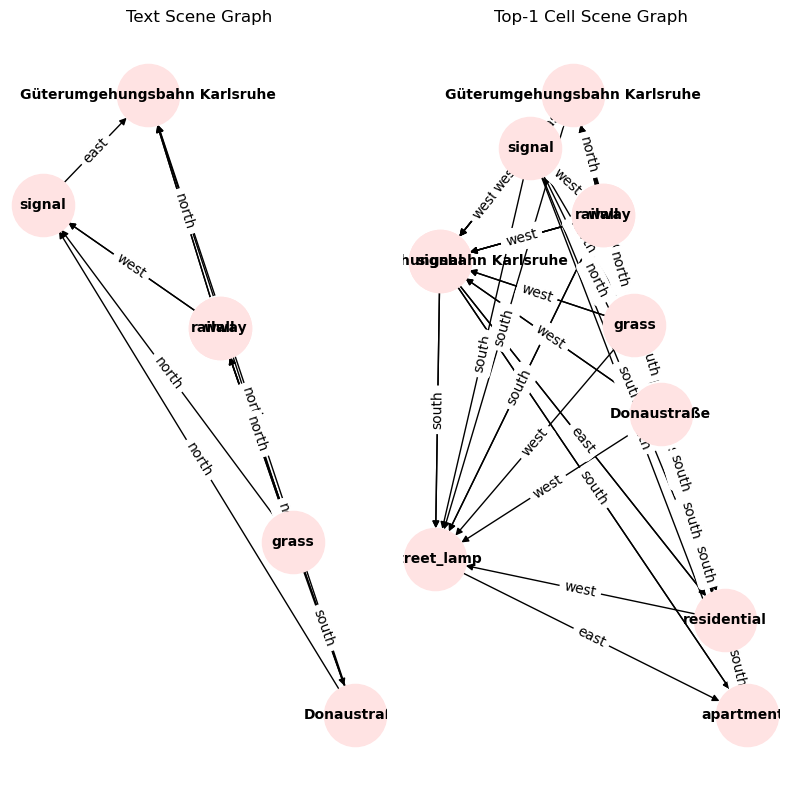

Text scene graph_key: 0009_0401_00002
Cell scene graph_key 0009_0401


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


<Figure size 640x480 with 0 Axes>

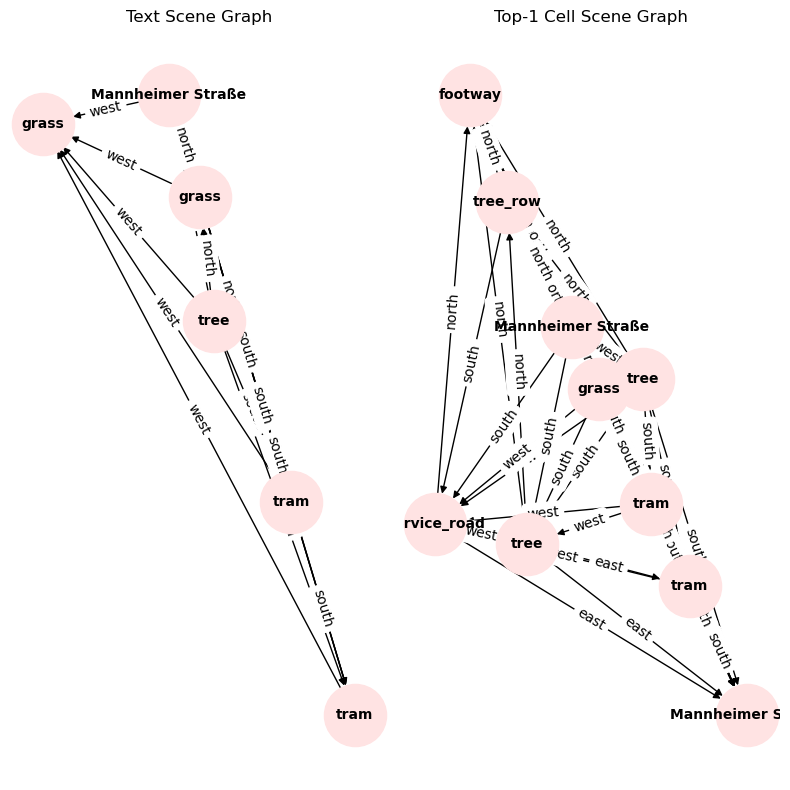

Text scene graph_key: 0000_0509_00000
Cell scene graph_key 0000_0050


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


<Figure size 640x480 with 0 Axes>

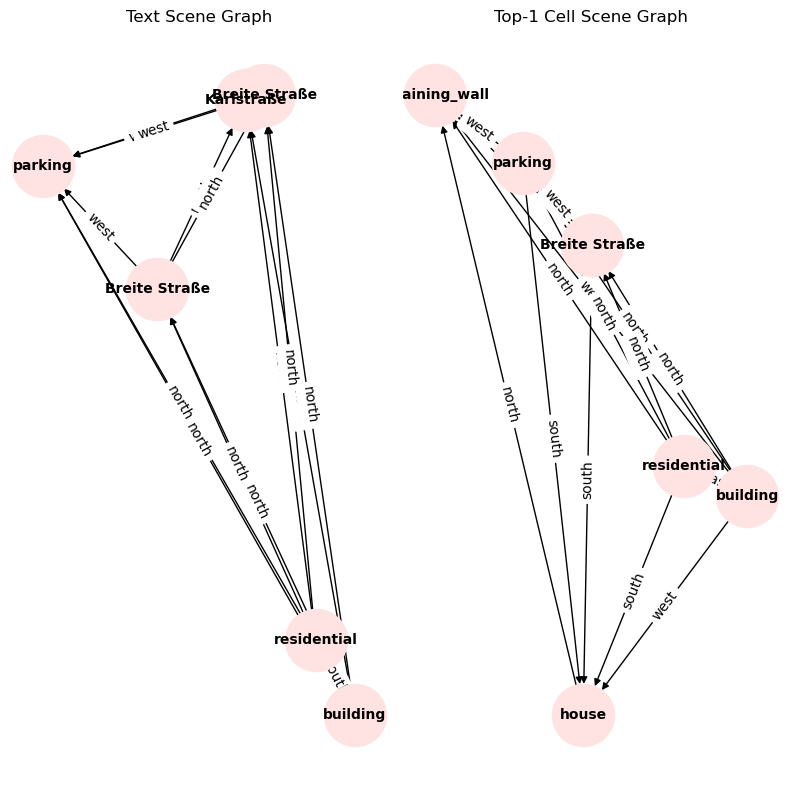

Text scene graph_key: 0010_0149_00004
Cell scene graph_key 0010_0149


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


<Figure size 640x480 with 0 Axes>

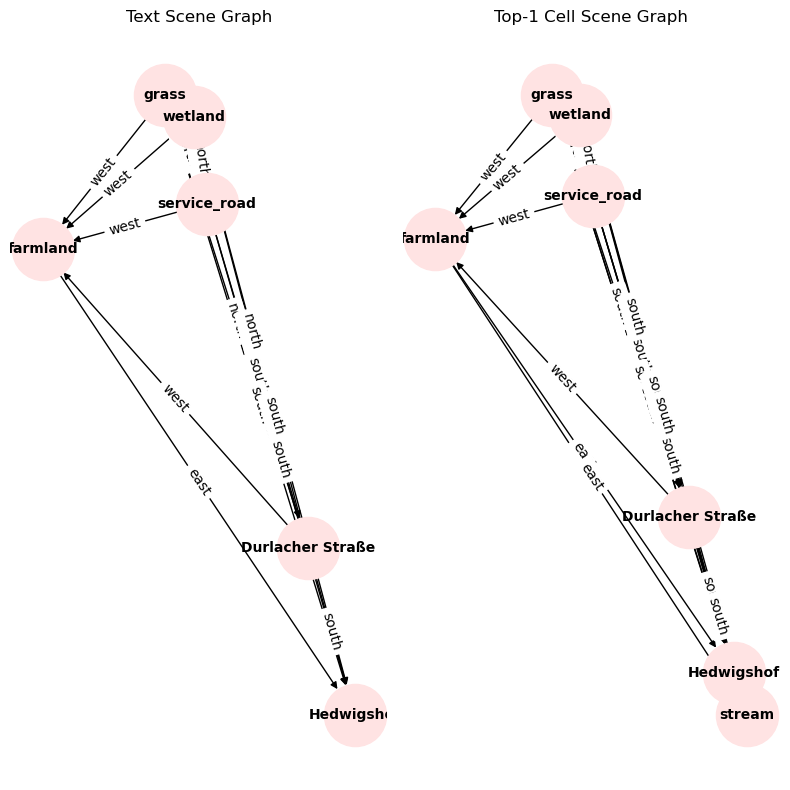

Text scene graph_key: 0007_1700_00000
Cell scene graph_key 0007_1700


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


<Figure size 640x480 with 0 Axes>

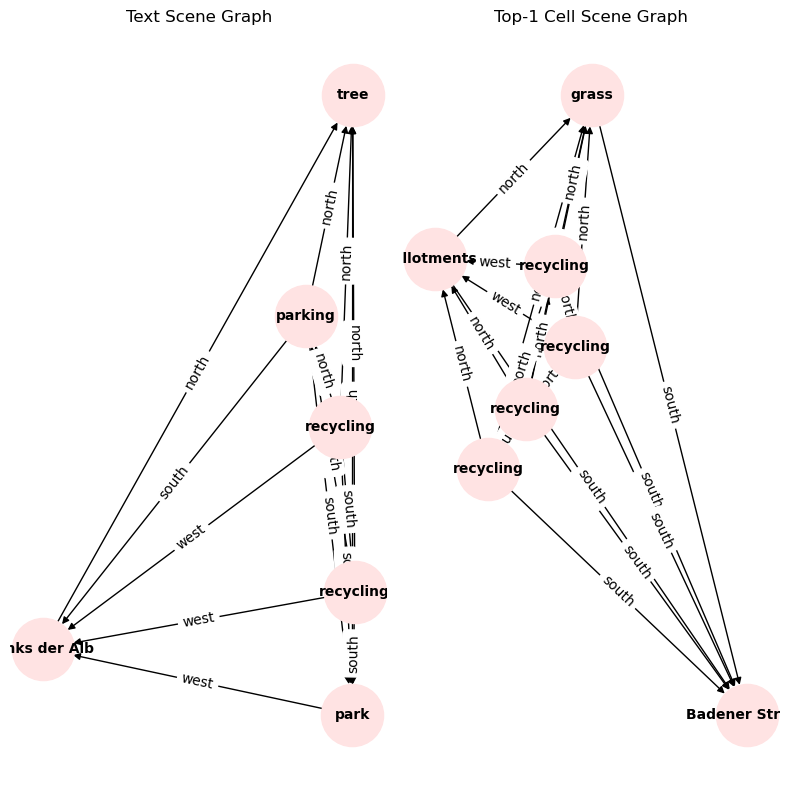

Text scene graph_key: 0009_3178_00003
Cell scene graph_key 0003_0582


<Figure size 640x480 with 0 Axes>

In [9]:
for index in np.random.randint(0, len(text_scene_graph_keys), 5):
    text_scene_graph_key = text_scene_graph_keys[index] 
    text_scene_graph = text_scene_graphs[text_scene_graph_key]
    text_scene_graph_dict = {text_scene_graph_key: text_scene_graph}

    accuracy, cos_sims_dict, sorted_top_k_cell_ids = eval(model, text_scene_graph_dict, cell_scene_graphs, cell_graph_keys, [1, 3, 5])

    graph1, pos1 = scene_graph_to_osmnx_graph(text_scene_graph)

    cell_scene_graph_keys = list(cell_scene_graphs.keys())
    top_one_cell_scene_graph_key = sorted_top_k_cell_ids[0]
    cell_scene_graph = cell_scene_graphs[top_one_cell_scene_graph_key]
    graph2, pos2 = scene_graph_to_osmnx_graph(cell_scene_graph)

    visualize_osmnx_graphs_side_by_side(
        graph1, graph2, 
        pos1, pos2, 
        figsize=(8, 8), 
        node_size=2000, 
        font_size=10, 
        edge_font_size=10, 
        title1="Text Scene Graph", 
        title2="Top-1 Cell Scene Graph"
    )
    print('Text scene graph_key:', text_scene_graph_key)
    print('Cell scene graph_key', top_one_cell_scene_graph_key)

# Качество модели на валидации

In [10]:
val_graph_keys = val_scene_graphs.keys()
val_graph_keys = ["_".join(k.split("_")[:2]) for k in val_graph_keys]
val_graph_keys = list(set(val_graph_keys))
val_scene_ids = list(set([k.split("_")[0] for k in val_graph_keys]))

cell_graphs_copy = copy.deepcopy(cell_scene_graphs)
for k,v in cell_scene_graphs.items():
    seq_name, seq_cell_id = k.split("_")
    if seq_name not in val_scene_ids:
        del cell_graphs_copy[k]
cell_graph_keys = list(cell_graphs_copy.keys())
accuracy, cos_sims_dict, _ = eval(model, val_scene_graphs, cell_graphs_copy, cell_graph_keys, [1, 3, 5])
recalls = [0] * len(config.top_ks_list)
for k,v in accuracy.items():
    for acc_i, acc in enumerate(v):
        if acc:
            recalls[acc_i] += 1
recalls = np.array(recalls, dtype=float)
recalls /= len(accuracy)
recalls = recalls.tolist()
print("Val recalls:")
for i, k in enumerate([1, 3, 5]):
    print(f"Recal@{k}:", recalls[i])

Evaluating: 100%|██████████| 1519/1519 [04:09<00:00,  6.09it/s]

Val recalls:
Recal@1: 0.26201448321263987
Recal@3: 0.5246872942725477
Recal@5: 0.6761026991441738


## Как считаются метрики

Метрики рассчитываются следующим образом:

1. Для каждого текстового графа сцены модель получает эмбеддинги, а затем сравнивает их с эмбеддингами графов клеток (cell scene graphs) с помощью косинусного расстояния (точнее, вычисляется 1 - cosine_similarity).

2. Все графы клеток сортируются по возрастанию косинусного расстояния, что позволяет получить топ-k наиболее похожих графов для каждого текстового графа.

3. Для каждого текстового графа извлекается его идентификатор и сравнивается с идентификаторами графов клеток в топ-k. Если нужный граф присутствует в топ-k, соответствующая позиция в списке результатов для данного запроса помечается как True.

4. Получаем абсолютное число попаданий в топ-k. 

5. Затем для каждого значения k вычисляется recall как доля текстовых графов, у которых правильный граф присутствует в топ-k:
    Recall@k = (количество запросов с корректным результатом в топ-k) / (общее число текстовых графов).

# Модель

![ff](/home/bukkacha/Desktop/CCM/GOTLoc/photo_2025-04-29_08-47-14.jpg)

Модель генерации эмбеддингов представляет с собой графовый трансформер. На вход получает два графа в формате PyTorch Geometric. Графы проходят через $N$ слоев self-attention-а, далее строится двудольный граф между вершинами из двух исходных графов и новый граф еще раз прогоняется через $N$ слоев self-attention. На граифке TSA --- Text-Self-Attention, GSA --- Graph-Self-Attention, TCA --- Text-Cross-Attention, GCA --- Graph-Cross-Attention. После слоев внимания производится mean-pooling и на выходе получаем эмбеддинги текста и ячейки-карты.

Лосс-функция состоит из двух частей $\mathcal{L} = \mathcal{L}_{matching} + \mathcal{L}_{similarity}$. $\mathcal{L}_{matching} = \operatorname{MLP}(E^T \| E^M)$, где $\|$ --- обозначает конкатенацию, и $\mathcal{L}_{similarity} = \frac{\langle E^T, E^M \rangle}{\|E^T\| \|E^M\|}$. 

# Ресурсы на инференс

In [11]:
from torch.profiler import profile, record_function, ProfilerActivity

activities = [ProfilerActivity.CUDA]
sort_by_keyword = 'cuda_time_total'


with profile(activities=activities, record_shapes=True) as prof:
    with record_function("model_inference"):
        scene_graph_pyg = val_scene_graphs['0010_0005_00000'].to_pyg()
        p_node_ft, p_edge_idx, p_edge_ft = scene_graph_pyg
        x_node_ft, x_edge_idx, x_edge_ft = text_scene_graphs['0010_0005_00000'].to_pyg()
        model(
            torch.tensor(np.array(x_node_ft), dtype=torch.float32).to('cuda'), 
            torch.tensor(np.array(p_node_ft), dtype=torch.float32).to('cuda'),
            torch.tensor(x_edge_idx, dtype=torch.int64).to('cuda'), 
            torch.tensor(p_edge_idx, dtype=torch.int64).to('cuda'),
            torch.tensor(np.array(x_edge_ft), dtype=torch.float32).to('cuda'), 
            torch.tensor(np.array(p_edge_ft), dtype=torch.float32).to('cuda')
        )

print(prof.key_averages().table(sort_by=sort_by_keyword, row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void gemmSN_TN_kernel<float, 128, 16, 2, 4, 6, 7, fa...         0.00%       0.000us         0.00%       0.000us       0.000us     261.442us        36.94%     261.442us      16.340us            16  
                         volta_sgemm_32x32_sliced1x4_tn         0.00%       0.000us         0.00%       0.000us       0.000us     105.504us        14.91%     105.504us      26.376us             4  
void at::

Время выполнения на CUDA почти 750 микросекунд, что очень быстро.

In [13]:
from torchinfo import summary
summary(model, 
        input_data=(torch.tensor(np.array(x_node_ft), dtype=torch.float32).to('cuda'), 
                    torch.tensor(np.array(p_node_ft), dtype=torch.float32).to('cuda'),
                    torch.tensor(x_edge_idx, dtype=torch.int64).to('cuda'), 
                    torch.tensor(p_edge_idx, dtype=torch.int64).to('cuda'),
                    torch.tensor(np.array(x_edge_ft), dtype=torch.float32).to('cuda'), 
                    torch.tensor(np.array(p_edge_ft), dtype=torch.float32).to('cuda'))
)

Layer (type:depth-idx)                        Output Shape              Param #
BigGNN                                        [300]                     --
├─ModuleList: 1-1                             --                        --
│    └─SimpleTConv: 2-1                       [6, 300]                  --
│    │    └─TransformerConv: 3-1              [6, 300]                  812,100
│    │    └─LeakyReLU: 3-2                    [6, 300]                  --
├─ModuleList: 1-2                             --                        --
│    └─SimpleTConv: 2-2                       [6, 300]                  --
│    │    └─TransformerConv: 3-3              [6, 300]                  812,100
│    │    └─LeakyReLU: 3-4                    [6, 300]                  --
├─ModuleList: 1-3                             --                        --
│    └─SimpleTConv: 2-3                       [12, 300]                 --
│    │    └─TransformerConv: 3-5              [12, 300]                 812,100
│    

Один прогон модели потребляет около 16 Мб данных. Количество параметров равно 3,789,601. 

In [19]:
from ptflops import get_model_complexity_info

def input_constructor(input_shape):
    return {
        'x_1': torch.tensor(np.array(x_node_ft), dtype=torch.float32).to('cuda'), 
        'x_2': torch.tensor(np.array(p_node_ft), dtype=torch.float32).to('cuda'),
        'edge_idx_1': torch.tensor(x_edge_idx, dtype=torch.int64).to('cuda'), 
        'edge_idx_2': torch.tensor(p_edge_idx, dtype=torch.int64).to('cuda'),
        'edge_attr_1': torch.tensor(np.array(x_edge_ft), dtype=torch.float32).to('cuda'), 
        'edge_attr_2': torch.tensor(np.array(p_edge_ft), dtype=torch.float32).to('cuda')
    }

macs, params = get_model_complexity_info(
    model, (1, ), as_strings=False, backend='pytorch', input_constructor=input_constructor,
    print_per_layer_stat=False,
    verbose=False
)
print(f"MMACs: {macs / 1e6}, Params: {params}")

Warning! No positional inputs found for a module, assuming batch size is 1.
MMACs: 0.552901, Params: 3789601


Сложность составляет 0.55 мега-MACs. 

# Обучение модели

В репозитории имеется возможность дообучения модели. Для этого можно в файле config.py поставить True в соответствующей переменной и запустить train.py. Для иллюстарции обучения и получения модели с другими гиперпараметрами обучим модель в ноутбуке. Также в репозитории имеется возможность логирования в wandb.

In [4]:
def cross_entropy(preds, targets, reduction='none', dim=-1):
    log_softmax = torch.nn.LogSoftmax(dim=dim) 
    loss = (-targets * log_softmax(preds)).sum(1)
    assert(all(loss >= 0))
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()   

def train(model, optimizer, database_3dssg, dataset, batch_size):
    assert(type(dataset) == list)
    indices = [i for i in range(len(dataset))]
    random.shuffle(indices)
    train_loss = 0
    batched_indices = [indices[i:i+batch_size] for i in range(0, len(indices) - batch_size, batch_size)]
    assert(len(batched_indices[0]) == batch_size)
    skipped = 0
    total = 0
    loss_cnt = 0
    for batch in tqdm(batched_indices, leave=False):
        loss1 = torch.zeros((len(batch), len(batch))).to('cuda')
        loss3 = torch.zeros((len(batch), len(batch))).to('cuda')
        for i in range(len(batch)):
            for j in range(i, len(batch)):
                total += 1
                query = dataset[batch[i]]
                db = database_3dssg[dataset[batch[j]].scene_id]
                query_subgraph, db_subgraph = query, db

                x_node_ft, x_edge_idx, x_edge_ft = query_subgraph.to_pyg()
                p_node_ft, p_edge_idx, p_edge_ft = db_subgraph.to_pyg()
                if len(x_edge_idx[0]) < 1 or len(p_edge_idx[0]) < 1:
                    skipped += 1
                    loss1[i][j] = 1
                    loss1[j][i] = loss1[i][j]
                    loss3[i][j] = 0.5
                    loss3[j][i] = loss3[i][j]
                    continue
                x_p, p_p, m_p = model(torch.tensor(np.array(x_node_ft), dtype=torch.float32).to('cuda'), torch.tensor(np.array(p_node_ft), dtype=torch.float32).to('cuda'),
                                        torch.tensor(x_edge_idx, dtype=torch.int64).to('cuda'), torch.tensor(p_edge_idx, dtype=torch.int64).to('cuda'),
                                        torch.tensor(np.array(x_edge_ft), dtype=torch.float32).to('cuda'), torch.tensor(np.array(p_edge_ft), dtype=torch.float32).to('cuda'))
                x_node_ft, x_edge_idx, x_edge_ft = None, None, None

                loss1[i][j] = 1 - F.cosine_similarity(x_p, p_p, dim=0) # [0, 2] 0 is good
                loss1[j][i] = loss1[i][j]
                loss3[i][j] = m_p
                loss3[j][i] = loss3[i][j]
        loss1_t = (torch.ones((len(batch), len(batch))).to('cuda') - torch.eye(len(batch)).to('cuda')) * 2
        loss3_t = torch.eye(len(batch)).to('cuda')

        # Cross entropy
        loss1 = cross_entropy(loss1, loss1_t, reduction='mean', dim=1)
        loss3 = cross_entropy(loss3, loss3_t, reduction='mean', dim=1)
        if (config.loss_ablation_m): loss = loss1     # Cosine similarity only
        elif (config.loss_ablation_c): loss = loss3   # Matching probability only
        else: loss = (loss1 + loss3) / 2.0          # Average of both

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss_cnt += 1
    train_loss /= loss_cnt
    return train_loss, loss1.item(), loss3.item()

In [5]:
layers = 2
heads = 1
new_model = BigGNN(layers, heads).to('cuda')
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.0001, weight_decay=5e-5)

train_text_graphs = list(train_scene_graphs.values())
epochs = 10
index = 1000
text_scene_graph_key = text_scene_graph_keys[index] 
text_scene_graph = text_scene_graphs[text_scene_graph_key]
text_scene_graph_dict = {text_scene_graph_key: text_scene_graph}

wandb.init(
    project="GOTLoc",
    name="BigGNN",
    mode="online",
    config={
        "layers": layers,
        "heads": heads
    }
)

rerun.save("training_graphs.rrd")
    
for epoch in tqdm(range(epochs)):
    new_model.train()
    train_loss, sim_loss, matching_loss = train(
        new_model,
        optimizer=optimizer, 
        database_3dssg=cell_scene_graphs, 
        dataset=train_text_graphs, 
        batch_size=16
    )

    new_model.eval()
    accuracy, _, sorted_top_k_cell_ids = eval(new_model, text_scene_graph_dict, cell_scene_graphs, cell_graph_keys, [5])

    top_one_cell_scene_graph_key = sorted_top_k_cell_ids[0]
    cell_scene_graph = cell_scene_graphs[top_one_cell_scene_graph_key]

    edge_scale_factor = 100
    rerun.log(
        "GOTLoc_training",
        rerun.GraphNodes(
            node_ids=list(cell_scene_graph.nodes.keys()),
            positions=[(node.centroid[0]*edge_scale_factor, node.centroid[1]*edge_scale_factor) for node in cell_scene_graph.nodes.values()],
            labels=[node.label for node in cell_scene_graph.nodes.values()],
        ),
        rerun.GraphEdges(
            edges=[(source_id, target_id) for source_id, target_id in zip(cell_scene_graph.edge_idx[0], cell_scene_graph.edge_idx[1])], 
            graph_type="directed"
        ),
    )

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "sim_loss": sim_loss,
        "matching_loss": matching_loss,
    })

wandb: Currently logged in as: shashlik to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


  0%|          | 0/411 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Обучение заняло на GTX 1650 около 3 часов.

Ссылка на лог в wandb: https://wandb.ai/shashlik/GOTLoc?nw=nwusershashlik

In [6]:
torch.save(new_model.state_dict(), f'outputs/layers={layers}_heads={heads}.pt')

In [7]:
cell_graphs_copy = copy.deepcopy(cell_scene_graphs)
accuracy, cos_sims_dict, _ = eval(new_model, val_scene_graphs, cell_graphs_copy, cell_graph_keys, [1, 3, 5])
recalls = [0] * len(config.top_ks_list)
for k,v in accuracy.items():
    for acc_i, acc in enumerate(v):
        if acc:
            recalls[acc_i] += 1
recalls = np.array(recalls, dtype=float)
recalls /= len(accuracy)
recalls = recalls.tolist()
print("Val recalls:")
for i, k in enumerate([1, 3, 5]):
    print(f"Recal@{k}:", recalls[i])

Evaluating: 100%|██████████| 1519/1519 [07:39<00:00,  3.31it/s]

Val recalls:
Recal@1: 0.15075707702435814
Recal@3: 0.3607636603028308
Recal@5: 0.4970375246872943


Если хотите посмотреть графы, то выполните следующую ячейку.

In [9]:
!rerun view training_graphs.rrd

[2025-05-12T18:10:22Z INFO  re_data_loader::load_file] Loading "training_graphs.rrd"…
[2025-05-12T18:10:22Z INFO  re_grpc_server] Listening for gRPC connections on 0.0.0.0:9876. Connect by running `rerun --connect rerun+http://127.0.0.1:9876/proxy`
[2025-05-12T18:10:22Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-05-12T18:10:22Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-05-12T18:10:22Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-05-12T18:10:22Z INFO  egui_wgpu] There were 4 available wgpu adapters: {backend: Vulkan, device_type: IntegratedGpu, name: "Intel(R) UHD Graphics (CML GT2)", driver: "Intel open-source Mesa driver", driver_info: "Mesa 23.2.1-1ubuntu3.1~22.04.3", vendor: Intel (0x8086), device: 0x9BC4}, {backend: Vulkan, device_type: Cpu, name: